# Chapter 7: Combining different models for ensemble learning


## Learning with ensembles

*Ensemble methods* combine multiple estimators into a single estimator that has better generalization than each classifier alone.  Many use *majority voting*, meaning a label must recieve more than 50% of the 'votes' in the component models; a generalization can be made with *plurality voting*, where the final label is decided by the label with the most votes.

This can be written as:
$$
    \hat{y}  = \text{mode}\{C_1(x), \dots, C_m(x)\}
$$ 
for $m$ models.  If the error rates of each classifier are independent and all have an equal error rate, $\epsilon$, then:
$$
    P(y \geq k) = \sum_k^n \left\langle \begin{matrix} n \\ k \end{matrix} \right\rangle \epsilon^k(1-\epsilon)^{n-k} = \epsilon_{ensemble}
$$
Note that $\epsilon \leq 0$.  Therefore the error rate of the ensemble must be lower.  This sum can be implemented and graphed in Python.

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)     

0.03432750701904297

From the graph below it is clear that the ensemble error is always better than the base error.

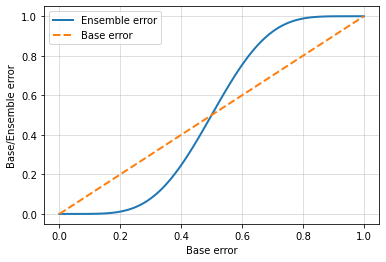

In [2]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error') 
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## Combining classifier via majority vote

### Implementing a simple majority vote classifier

We will implement a weighted voting classifier.  A prediction can be written as:
$$
    \hat{y} = \text{arg max} \sum{j=1}^m w_j \chi_A(C_j(x) = i)
$$
where:
- $w_j$ is the weight of the $j$th classifier
- $A$ is the set of unique class labels
- $\chi_A$ is the characteristic function which returns 1 if the predicted class label matches the actual class label, $C_j(x) = i$

If the weights are uniform (i.e. all the classifiers are considered equally) then: 
$$
    \hat{y}  = \text{mode}\{C_1(x), \dots, C_m(x)\}
$$ 

`Numpy` has the `argmax` and `bincount` functions, so the weights can be easily implemented:

In [3]:
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

One way to decide the weights is to use a classifier that can return the probability of a class label prediction via the `predict_proba` funciton of the estimator. Then:
$$
 \hat{y} = \text{argmax} \sum_{j=1}^m w_j p_{ij}
$$
where $p_{ij}$ is the probability of the $j$th classifier for the class label $i$.

This can be implemented using the `average` function of Numpy:

In [4]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p, np.argmax(p)

(array([0.58, 0.42]), 0)

#### Code implementation

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

# inherit BaseEstimator and ClassifierMixin to get the 
# get_params and set_params and score functionalities
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote = 'classlabel', weights = None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key, value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel' got (vote={self.vote}")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal; got {len(self.weights)} weights, {len(self.classifiers)} classifiers')
        self.lablenc_ = LabelEncoder() #ensures labels are 0 to n
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(x), axis = 1)
        else: #must be classlabel
            predictions = np.asarray(
                [clf.predict(X) for clf in self.classifiers_]
            ).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights = self.weights)),
                axis = 1,
                arr = predictions
            )
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.array(
            [clf.predict_proba(X) for clf in self.classifiers_]
        )
        avg_proba = np.average(probas, axis = 0, weights = self.weights)
        return avg_proba
    
    #override the super class' get_params method
    def get_params(self, deep = True):
        if not deep:
            return super().get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep = True).items():
                    out[f"{name}__{key}"] = value
            return out

### Using the majority voting principle to make predictions

Use the iris dataset with only sepal width and petal length (they are less correlated, thus making the classification more difficult); moreover, only try to predict versicolor or virginica.

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =train_test_split(
    X, y,
    test_size=0.5,
    random_state=1,
    stratify=y
)

Now use the following classifiers:
- logistic regression
- decision tree
- k-nearest neighbors

In [7]:
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np
#make the models
clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1) 
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0) 
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski') 
#need to also scale the data
pipe1 = Pipeline([['sc', StandardScaler()],['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN'] 
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='roc_auc'
    )
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


Now apply the voting classifier:

In [8]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
        X = X_train,
        y = y_train,
        cv = 10,
        scoring = 'roc_auc'
    )
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


### Evaluating and tuning the ensemble classifier

Evaluation is done by the ROC curve for test data.  The MajorityVoteClassifier performs as well or better than the singular models.

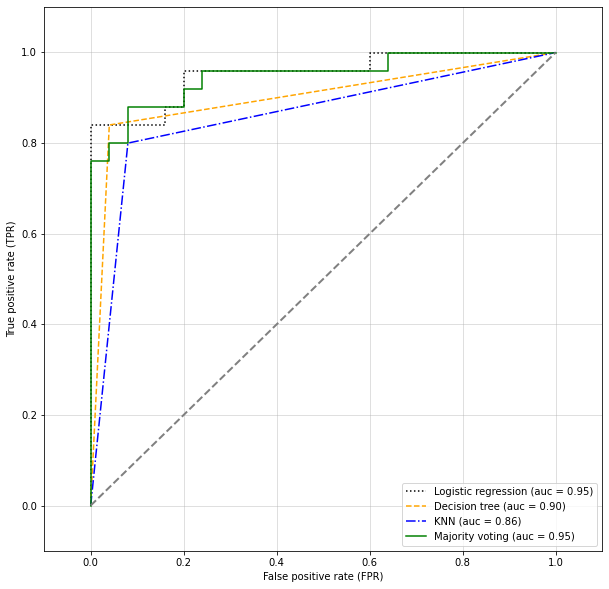

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green'] 
linestyles = [':', '--', '-.', '-']
plt.figure(figsize = (10,10))
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles): 
    # assuming the label of the positive class is 1 
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr,
             tpr,
             color = clr,
             linestyle = ls,
             label=f'{label} (auc = {roc_auc:.2f})'
            )
plt.legend()
plt.plot(
    [0,1], [0, 1],
    linestyle = '--',
    color = 'grey',
    linewidth = 2)
plt.xlim([-0.1, 1.1]) 
plt.ylim([-0.1, 1.1]) 
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)') 
plt.ylabel('True positive rate (TPR)') 
plt.show()

We can also plot the decision region.  The data is scaled so that the scale for all the data is the same (note that the KNN and LR models already scale the data, but the Decision Tree does not).

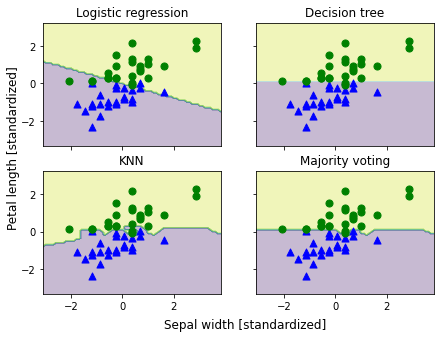

In [10]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train) 
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)) 
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                    all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                 X_train_std[y_train==0, 1],
                                 c = 'blue',
                                 marker = '^',
                                 s = 50
                                 )
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train==1, 1],
                                 c = 'green',
                                 marker = 'o',
                                 s = 50
                                 )
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5., s='Sepal width [standardized]', ha='center', va='center', fontsize=12) 
plt.text(-12.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90) 
plt.show()

In order to tune the ensemble classifier, we can tune the constituent  models.  Note how the ensemble holds the parameters of the model:

In [11]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

Now we can set the parameters with the GridSearch

In [15]:
from sklearn.model_selection import GridSearchCV
#we pass the parameters using the above reference types from get_params:
params = {'decisiontreeclassifier__max_depth': [1, 2], 
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]} 
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc') 
grid.fit(X_train, y_train)
#now print out the results for the gridsearch
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')
print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC : {grid.best_score_:.2f}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC : 0.98


#### Alternative: stacking ensemble

*Stacking* uses a two level model.  The first level is fit to the data, then a second level is fit to the first level predictions.  Then the model is used to make final predictions.

## Bagging – building an ensemble of classifiers from bootstrap samples

*Bagging* refers to drawing bootstrap samples to train the models within the ensemble. Also known as *bootstrap aggregating*. 

### Bagging in a nutshell

Consider a training dataset.  $m$ bagging rounds draw training samples, training $C_m$ models.

### Applying bagging to classify examples in the Wine dataset

Use only two classes and only two features.

In [24]:
import pandas as pd
df_wine = pd.read_csv('wine_data.csv').drop(columns = ['Unnamed: 0'])
df_wine.columns = ['Class label', 'Alcohol',
    'Malic acid', 'Ash',
    'Alcalinity of ash',
    'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines',
    'Proline']
 # drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1] 
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                 test_size=0.2,
                 random_state=1,
                 stratify=y)

Scikit-learn has a `BaggingClassifier` that we can use:

In [26]:
from sklearn.ensemble import BaggingClassifier 
tree = DecisionTreeClassifier(criterion='entropy', 
                              random_state=1, 
                              max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)


Now we can compare an untrimmed tree model and the bagging classifier by the accuracy metric.

In [27]:
from sklearn.metrics import accuracy_score 
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred) 
tree_test = accuracy_score(y_test, y_test_pred) 
print(f'Decision tree train/test accuracies {tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


In [28]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print(f'Bagging train/test accuracies {bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies 1.000/0.917


The decision tree's test accuracy indicates high variance. However, the bagging model significantly reduces the variance.

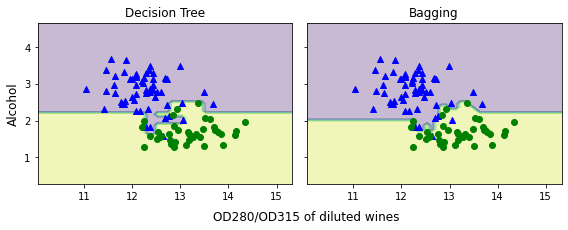

In [29]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)) 
f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3)) 
for idx, clf, tt in zip([0, 1], 
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c = 'green', marker = 'o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12) 
plt.tight_layout()
plt.text(0, -0.2,
    s='OD280/OD315 of diluted wines',
    ha='center',
    va='center',
    fontsize=12,
    transform=axarr[1].transAxes) 
plt.show()

When a model has high variance (especially with high dimensionality), bagging classifiers can be beneficial to reducing this variance. However, bagging is ineffective at reducing bias.  Hence bagging classifiers are best for models with high variance.

## Leverageing weak learners via adaptive boosting

*Boosting*: Allow weak classifiers to focus on data that is misclassified by other models in order to improve the overall performance. Boosting uses *weak learners*, or models that are little better than random guessing.

### How adaptive boosting works

The following is a typical boosting algorithm:
1. Draw a random subset of samples, $d_1$, from a training set, $D$, to train a weak learner, $C_1$.
2. Draw a second subset of samples, $d_2$, and add half of the missclassified examples from $C_1$ to train $C_2$.
3. Create $d_3$ of training samples that are misclassified y both $C_1$ and $C_2$ to train $C_3$.
4. Combine $C_1$, $C_2$ and $C_3$ into an ensemble majority vote model.

*AdaBoost* is a common implementation that uses the entire data set to train the weak classifiers, but reweights the training samples that are misclassified.  The algorithm is as follows:
1. Set the weight vector, $w$, to uniform weights where $\sum w_i = 1$.
2. For $j$ and $m$ boosting rounds:
    1. Train $C_j = train(X, y, w)$
    2. Predict: $\hat{y} = predict(C_j, X)$
    3. Compute the weighted error: $\epsilon = w \cdot (\hat{y} \neq y)$
    4. Compute the coefficient: $a_j = 0.5 \log \frac{1 - \epsilon}{\epsilon}$
    5. update the weights: $w := w \times \exp (- a_j \times \hat{y} \times y)$
    6. Normalize weights to sum to one: $w := \frac{w}{\sum w_i}$
3. Compute the final prediction: $\hat{y} = (\sum_{j=1}^m (a_j \times \text{predict}(C_j, X)) > 0)$

